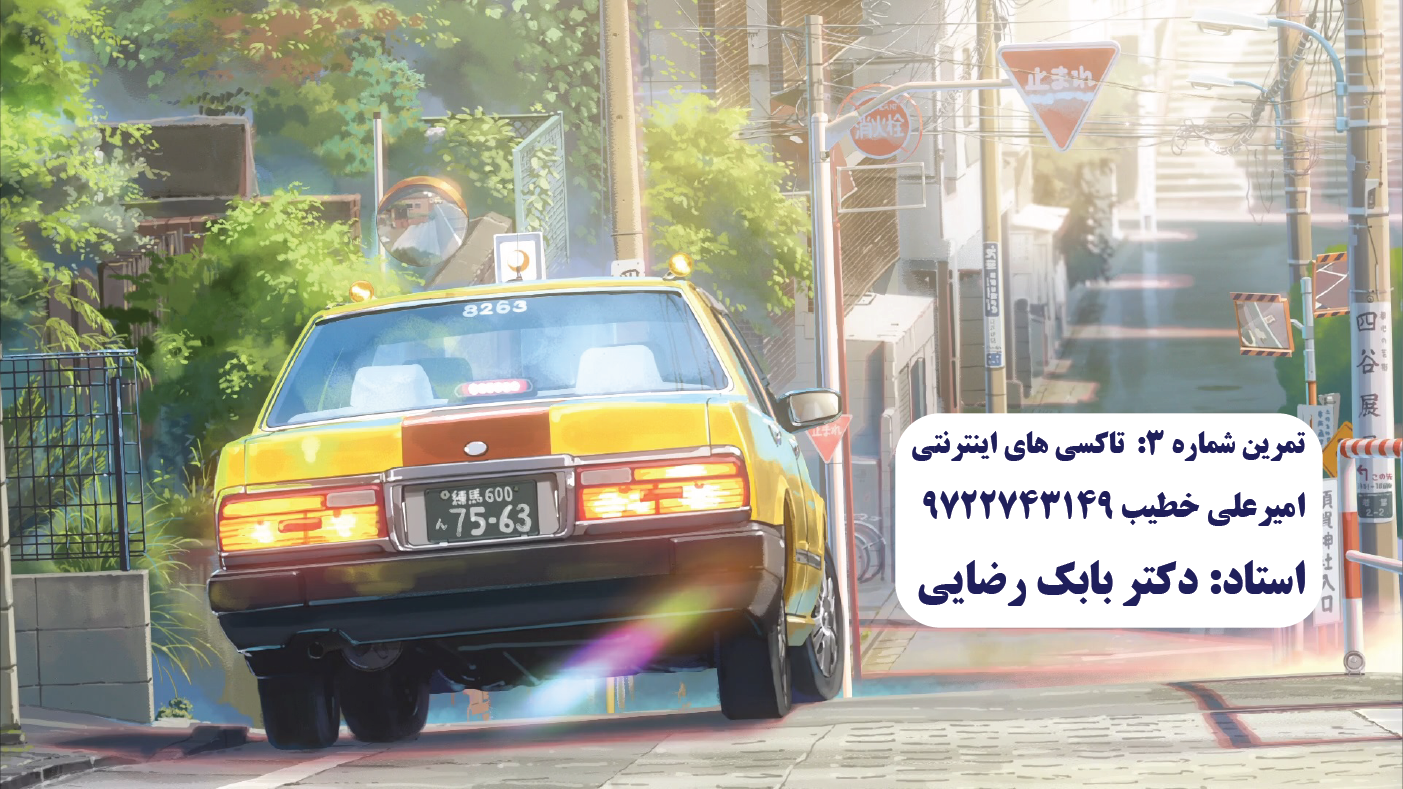

# داده های اولیه 

In [1]:
import numpy as np

T = 150
req_num = 100
users = np.array(
    [[1001, 1, 1], [1002, 1, 1], [1003, 0, 1], [1004, 1, 1], 
     [1005, 1, 1], [1006, 1, 1], [1007, 0, 1], [1008, 1, 1],
     [1009, 0, 1], [1010, 1, 1], [1011, 1, 1], [1012, 1, 1], 
     [1013, 1, 1], [1014, 1, 1], [1015, 1, 1], [1016, 1, 1],
     [1017, 1, 1], [1018, 1, 1], [1019, 0, 1], [1020, 1, 1],
     [3001, 0, 0], [3002, 0, 0], [3003, 1, 0], [3004, 0, 0], 
     [3005, 1, 0], [3006, 0, 0], [3007, 0, 0], [3008, 0, 0],
     [3009, 1, 0], [3010, 1, 0], [3011, 0, 0], [3012, 0, 0], 
     [3013, 1, 0], [3014, 0, 0], [3015, 1, 0], [3016, 0, 0],
     [3017, 1, 0], [3018, 0, 0], [3019, 1, 0], [3020, 0, 0], 
     [3021, 1, 0], [3022, 1, 0], [3023, 0, 0], [3024, 0, 0],
     [3025, 0, 0], [3026, 1, 0], [3027, 0, 0], [3028, 0, 0], 
     [3029, 1, 0], [3030, 0, 0]])

drivers = np.column_stack((
    np.arange(1001, 1021, 1),
    np.random.randint(1, 100, 20),
    np.random.randint(1, 100, 20),
    np.random.randint(0, 1, 20)))


trips = np.column_stack((
    np.arange(11111, 11111 + req_num, 1), 
    np.random.choice(users[users[:, 0] > 1999][:, 0], req_num),
    np.sort(np.random.randint(1, T, req_num)), 
    np.random.randint(1, 100, req_num),
    np.random.randint(1, 100, req_num), 
    np.random.randint(1, 100, req_num), 
    np.random.randint(1, 100, req_num)))

# توابع فاصله ها

In [2]:
def Manhattan(x1,y1,x2,y2):
    return (np.abs(x2 - x1) + np.abs(y2-y1))

def Euclidean(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

# تابع باز نویسی

In [3]:
def rewrite(drivers,trips,users):
    Drivers = drivers.copy()
    Trips = trips.copy()
    Users = users.copy()
    
    Users = np.column_stack(
                (Users[:,:],
                 np.zeros(len(Users),dtype = int)))   #cumulative time duration
    
    Trips = np.column_stack(
                (Trips[:,:],
                 np.zeros(len(Trips),dtype = int),    #driver id 
                 np.zeros(len(Trips),dtype = int),    #expense
                 np.zeros(len(Trips),dtype = int),    #time_duration
                 np.zeros(len(Trips),dtype = int),    #finish_time       
                 np.zeros(len(Trips),dtype = int)))   #distance
    Drivers = np.column_stack(
                (Drivers[:,:],
                 np.zeros(len(Drivers),dtype = int))) #cumulative distance
    
    return Drivers, Trips, Users

# تابع تخصیص دهنده

In [4]:
def allocator(drivers,trips,users,func):
    
    for i in range(len(trips)):
        step1 = drivers[drivers[:,3] <= trips[i,2]]  # time condition
        distance = []
        
        for J in range(len(step1)):
            if func == '1':
                distance.append(Manhattan(step1[J,1],step1[J,2],
                                          trips[i,3], trips[i,4]))  # 1,2  --->  3,4
            elif func == '2':
                distance.append(Euclidean(step1[J,1],step1[J,2],
                                          trips[i,3], trips[i,4]))  # 1,2  --->  3,4
        
        Min = min(distance)   
        
        for j in range(len(drivers)):
            
            if func == '1':
                cond1 = Manhattan(drivers[j,1],drivers[j,2],trips[i,3], trips[i,4]) == Min
            elif func == '2':
                cond1 = Euclidean(drivers[j,1],drivers[j,2],trips[i,3], trips[i,4]) == Min     
            cond2 = drivers[j,3] <= trips[i,2]
            
            if cond1 and cond2:
                if func == '1':
                    distance1 = Manhattan(trips[i,3], trips[i,4],trips[i,5],trips[i,6])
                elif func == '2':
                    distance1 = Euclidean(trips[i,3], trips[i,4],trips[i,5],trips[i,6])    
                time_duration = np.ceil(distance1 * (np.sin(trips[i,2]/1000) * 0.016 + 0.08))    
                drivers[j,1]  = trips[i,5]
                drivers[j,2]  = trips[i,6]
                drivers[j,3] += time_duration
                drivers[j,4] += distance1
                trips[i,7]    = drivers[j,0]
                trips[i,8]    = time_duration * (np.ceil(np.cos(trips[i,2]/12)) * 50 + 200)
                trips[i,9]    = time_duration
                trips[i,10]   = trips[i,2] + time_duration
                trips[i,11]   = distance1
                break
            else:
                continue
        
        
    tdur = np.column_stack((trips[:,1],trips[:,9]))
    for k in users[users[:,2] == 0][:,0]:
        c = users[users[:,0] == k]
        c[:,3] = np.sum(tdur[tdur[:,0] == k][:,1])
        users[users[:,0] == k] = c
             
    return drivers, trips, users

# تابع گزینه ها

In [5]:
def option(Drivers, Trips, Users):
    while True:
        click = input('''Press button...
(1)to find trips which start at the input time.
--------------------------------------------------------
(2)to caculate the cumulative value of income of 
trips which were finished before or have been just finished 
at the input time.
--------------------------------------------------------
(3)to find cumulative value of trips' time duration 
for the best costumer(s) with the related traveller id(s)
--------------------------------------------------------
(4)to find the most busy drives' cumulative distance
--------------------------------------------------------
(5)to find highest expense among the trips and show its
request number and start time.
--------------------------------------------------------
(6)to prcentage of lost demands
--------------------------------------------------------
(7)to classify the trips' origin coordinates into classes A,B,C,D and the percentage of their demands
--------------------------------------------------------
(8)to find which driver has done more travels than the other drivers from A to C
--------------------------------------------------------
(back)to return to the main menu
--------------------------------------------------------\n''')
        click = click.lower()
        if click == '1':
            start_time = int(input("Enter the trip's start time:\n"))
            t = Trips[Trips[:,7] != 0 ]
            option1 = t[t[:,2] == start_time]
            print('==================================================================')
            print('Here we have the trips information which started at %i:' %start_time)
            print(option1[:,0:9])
            print('==================================================================')
            continue
        elif click == '2':
            status_time = int(input("Enter the time:\n"))
            option2 = Trips[Trips[:,10] <= status_time]
            print('==================================================================')
            print('(req number , traveler id, driver id, expense)')
            print(option2[:,[0,1,7,8]])
            print('The cumulative value of expenses before %i is:\n' %status_time ,np.sum(option2[:,8]))
            print('==================================================================')
            continue     
        elif click == '3':
            max_dur = np.max(Users[:,3])
            option3 = Users[Users[:, 3] == max_dur]
            print('==================================================================')
            print('''Here we have the maximum cumulative time duration among 
travelers and the id number of traveler:\n''')
            print('\n(traveler id,cumulative time duration)')
            print(option3[:,[0,3]]) 
            print('==================================================================')
            continue  
        elif click == '4':
            max_distance = np.max(Drivers[:,4])
            option4 = Drivers[Drivers[:,4] == max_distance]
            print('==================================================================')
            print('''Here we have the maximum cumulative trip distance among 
drivers and the id number of driver:\n''')
            print('\n(driver id,cumulative trip distance)')
            print(option4[:,[0,4]])
            print('==================================================================')
            continue       
        elif click == '5':
            max_expense = np.max(Trips[:,8])
            option5 = Trips[Trips[:,8] == max_expense]
            print('==================================================================')
            print('''Here we have a request number of most expensive trip and
its start time:\n''','expense:',max_expense)
            print('\n(request number, start time)')
            print(option5[:,[0,2]]) 
            print('==================================================================')
            continue        
        elif click == '6':
            option6 = (sum(Trips[:,7] == 0)/len(Trips)) * 100
            print('==================================================================')
            print('Here we have the percentage of lost demand')
            print(option6,'%')  
            print('==================================================================')
            continue
        elif click == '7':
            print('''Here we have the the classification of trips into A to D areas and 
their demand percentage:\n\n''')
            t = Trips[Trips[:,7] != 0]
            #_________________________________________________________________________
            Trips_A = t[((t[:,3] <= 50) & (t[:,3] >= 1) & (t[:,4] <= 50) & (t[:,4] >= 1))]
            print('A:\n')
            print('(req number, x1 , y1, x2, y2)')
            print(Trips_A[:,[0,3,4,5,6]])
            print('The percentage of demands for A area is:', (len(Trips_A)/len(Trips))*100, '%')
            #_________________________________________________________________________
            Trips_B = t[((t[:,3] <= 100) & (t[:,3] >= 51) & (t[:,4] <= 50) & (t[:,4] >= 1))]
            print('B:\n')
            print('(req number, x1 , y1, x2, y2)')
            print(Trips_B[:,[0,3,4,5,6]])
            print('The percentage of demands for B area is:', (len(Trips_B)/len(Trips))*100, '%')
            #_________________________________________________________________________
            Trips_C = t[((t[:,3] <= 100) & (t[:,3] >= 51) & (t[:,4] <= 100) & (t[:,4] >= 51))]
            print('C:\n')
            print('(req number, x1 , y1, x2, y2)')
            print(Trips_C[:,[0,3,4,5,6]])
            print('The percentage of demands for C area is:', (len(Trips_C)/len(Trips))*100, '%')
            #_________________________________________________________________________
            Trips_D = t[((t[:,3] <= 50) & (t[:,3] >= 1) & (t[:,4] <= 100) & (t[:,4] >= 51))]
            print('D:\n')
            print('(req number, x1 , y1, x2, y2)')
            print(Trips_D[:,[0,3,4,5,6]])
            print('The percentage of demands for D area is:', (len(Trips_D)/len(Trips))*100, '%')
            #_________________________________________________________________________
            continue
        elif click == '8':
            print("Here we have drivers' id who have trips from A to C more than the other drivers")
            t = Trips[Trips[:,7] != 0 ]
            Trips_AC = t[((t[:,3] <= 50) & (t[:,3] >= 1) & (t[:,4] <= 50) & (t[:,4] >= 1) & 
                          (t[:,5] <= 100) & (t[:,5] >= 51) & (t[:,6] <= 100) & (t[:,6] >= 51))]
            TID_AC, counts = np.unique(Trips_AC[:,1], return_counts=True)
            result = np.column_stack((TID_AC, counts)) 
            result = result[result[:,1] == np.max(result[:,1])]
            print('(travelet id, number of trips from A to C)')
            print(result)
            continue
        elif click == 'back':
            break
        else:
            print('Invalid input')
            continue
        return None

# تابع گزارش

In [6]:
def report(drivers, trips, users):
    print("Welcome to the taxi report center!")
    while True:
        Exit = input('Press (E/e) to quit or press any key to continue:\n')
        Exit = Exit.lower()
        if Exit == 'e':
            break
        else:
            pass
        Drivers, Trips, Users = rewrite(drivers,trips,users)
        function = input('''press button... 
(1) if you want to use Manhattan method to compute the distances
================================================================
(2) if you want to use Euclidean method to comput the distances:
================================================================\n''')        
        if function == '1':
            Drivers, Trips, Users = allocator(Drivers, Trips, Users, function)
            option(Drivers, Trips, Users)
            continue
        elif function == '2':
            Drivers, Trips, Users = allocator(Drivers, Trips, Users, function)
            option(Drivers, Trips, Users)
            continue
        else:
            print("Invalid input")
            continue
    return None

# فراخوانی تابع

In [7]:
report(drivers,trips,users)

Welcome to the taxi report center!
Press (E/e) to quit or press any key to continue:
u
press button... 
(1) if you want to use Manhattan method to compute the distances
(2) if you want to use Euclidean method to comput the distances:
1
Press button...
(1)to find trips which start at the input time.
--------------------------------------------------------
(2)to caculate the cumulative value of income of 
trips which were finished before or have been just finished 
at the input time.
--------------------------------------------------------
(3)to find cumulative value of trips' time duration 
for the best costumer(s) with the related traveller id(s)
--------------------------------------------------------
(4)to find the most busy drives' cumulative distance
--------------------------------------------------------
(5)to find highest expense among the trips and show its
request number and start time.
--------------------------------------------------------
(6)to prcentage of lost demands
--